NLTK's VADER lexicon is already downloaded.
NLTK's VADER lexicon is already downloaded.
Fetching latest market news from Finviz...
Fetching latest market news from Finviz...
Successfully fetched 90 news headlines.
Successfully fetched 90 news headlines.
Starting sentiment analysis...
Starting sentiment analysis...
Sentiment analysis complete.
Sentiment analysis complete.
Appended new sentiment score to historical_sentiment.csv
Appended new sentiment score to historical_sentiment.csv

--- Analysis Results ---
Market News Sentiment Analysis

Top 5 Most Positive Headlines

- New ETF gives investors opportunity to act like private equity giant as shift away from public stocks picks up (Score: 0.65)

- Power play: Two money managers bet big on uranium, predict long shelf life for gains (Score: 0.59)

- Nigeria’s Central Bank Halts Dividends, Bonuses for Some Banks (Score: 0.56)

- Republicans may need an AI boom to pay for the 'big, beautiful bill' (Score: 0.54)

- ‘How to Train Your Dragon

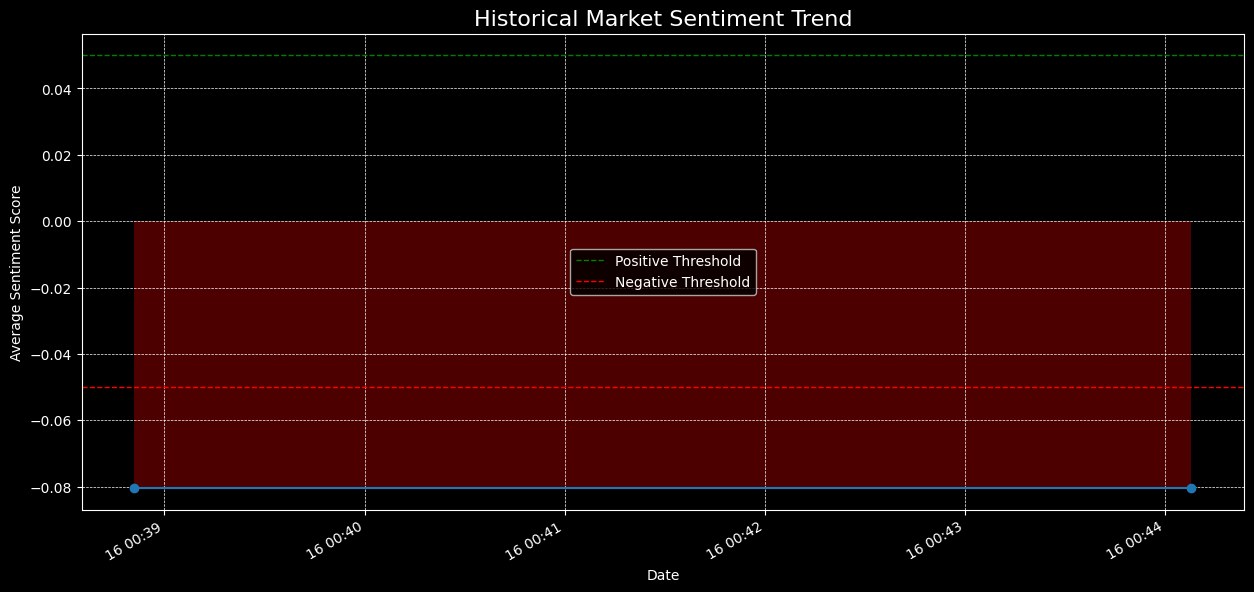

In [6]:
import pandas as pd
import nltk
from finvizfinance.news import News
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests
import os
from dotenv import load_dotenv
from datetime import datetime
import logging
import matplotlib.pyplot as plt

# --- 1. SETUP ---

# Load Environment Variables from .env file for Telegram credentials
load_dotenv()
TELEGRAM_BOT_TOKEN = os.getenv("TELEGRAM_BOT_TOKEN")
TELEGRAM_CHAT_ID = os.getenv("TELEGRAM_CHAT_ID")

# Configure Logging to file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='market_sentiment.log',
    filemode='a' # 'a' for append
)
# Also create a logger for console output
console_logger = logging.StreamHandler()
console_logger.setLevel(logging.INFO)
logging.getLogger('').addHandler(console_logger)


# --- 2. CORE FUNCTIONS ---

def setup_nltk():
    """Checks if the VADER lexicon is downloaded and, if not, downloads it."""
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
        logging.info("NLTK's VADER lexicon is already downloaded.")
    except LookupError:
        logging.info("NLTK's VADER lexicon not found. Downloading...")
        nltk.download('vader_lexicon')
        logging.info("Download complete.")

def fetch_market_news():
    """Fetches the latest market news from Finviz."""
    try:
        logging.info("Fetching latest market news from Finviz...")
        fnews = News()
        all_news = fnews.get_news()
        news_df = all_news['news']
        logging.info(f"Successfully fetched {len(news_df)} news headlines.")
        return news_df
    except Exception as e:
        logging.error(f"Error fetching news: {e}")
        return pd.DataFrame()

def analyze_sentiment(news_df):
    """Analyzes the sentiment of each news headline in the DataFrame."""
    if 'Title' not in news_df.columns:
        logging.error("Error: DataFrame does not contain a 'Title' column.")
        return news_df
    
    logging.info("Starting sentiment analysis...")
    vader = SentimentIntensityAnalyzer()
    scores = news_df['Title'].apply(lambda title: vader.polarity_scores(title))
    scores_df = pd.DataFrame(list(scores))
    scores_df.rename(columns={'compound': 'Compound Score'}, inplace=True)
    news_with_sentiment = news_df.join(scores_df['Compound Score'])
    logging.info("Sentiment analysis complete.")
    return news_with_sentiment

def save_historical_sentiment(average_sentiment):
    """Saves the current average sentiment score with a timestamp to a CSV file."""
    history_file = 'historical_sentiment.csv'
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    new_record = pd.DataFrame([{'timestamp': timestamp, 'average_sentiment': average_sentiment}])

    try:
        if not os.path.exists(history_file):
            new_record.to_csv(history_file, index=False)
            logging.info(f"Created and saved to {history_file}")
        else:
            new_record.to_csv(history_file, mode='a', header=False, index=False)
            logging.info(f"Appended new sentiment score to {history_file}")
    except Exception as e:
        logging.error(f"Failed to save historical sentiment: {e}")

def send_to_telegram(message):
    """Sends a message to a specified Telegram chat with a connection timeout."""
    if not TELEGRAM_BOT_TOKEN or not TELEGRAM_CHAT_ID:
        logging.warning("Telegram credentials not found in .env file. Skipping notification.")
        return

    api_url = f"https://api.telegram.org/bot{TELEGRAM_BOT_TOKEN}/sendMessage"
    try:
        response = requests.post(api_url, json={'chat_id': TELEGRAM_CHAT_ID, 'text': message, 'parse_mode': 'Markdown'}, timeout=10)
        response.raise_for_status()
        logging.info("Sentiment analysis successfully sent to Telegram.")
    except requests.exceptions.RequestException as e:
        logging.error(f"Error sending message to Telegram: {e}")

def format_and_dispatch_results(final_df, num_headlines=5):
    """Formats the results, prints to console, saves history, and sends to Telegram."""
    if final_df.empty:
        logging.warning("No data to process.")
        return
        
    sorted_df = final_df.sort_values(by='Compound Score', ascending=False).reset_index(drop=True)
    average_sentiment = sorted_df['Compound Score'].mean()

    # --- Save historical data before dispatching ---
    save_historical_sentiment(average_sentiment)

    # --- Build the message string for Telegram ---
    message_lines = ["*Market News Sentiment Analysis*"]
    message_lines.append(f"\n*Top {num_headlines} Most Positive Headlines*")
    for _, row in sorted_df.head(num_headlines).iterrows():
        message_lines.append(f"\n- {row['Title']} `(Score: {row['Compound Score']:.2f})`")
    message_lines.append(f"\n*Top {num_headlines} Most Negative Headlines*")
    for _, row in sorted_df.tail(num_headlines).iloc[::-1].iterrows():
        message_lines.append(f"\n- {row['Title']} `(Score: {row['Compound Score']:.2f})`")
    if average_sentiment > 0.05: overall_feeling = "Generally Positive"
    elif average_sentiment < -0.05: overall_feeling = "Generally Negative"
    else: overall_feeling = "Generally Neutral"
    message_lines.append("\n\n*Overall Market Sentiment*")
    message_lines.append(f"Average Score: `{average_sentiment:.3f}`")
    message_lines.append(f"Feeling: *{overall_feeling}*")
    full_message = "\n".join(message_lines)
    
    # --- Dispatch ---
    logging.info("\n--- Analysis Results ---\n" + full_message.replace('*', '').replace('`', ''))
    send_to_telegram(full_message)

def plot_historical_data():
    """Reads the historical data and plots the sentiment trend."""
    history_file = 'historical_sentiment.csv'
    logging.info(f"Attempting to plot data from {history_file}...")
    try:
        df = pd.read_csv(history_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(df['timestamp'], df['average_sentiment'], marker='o', linestyle='-', color='#1f77b4')
        ax.axhline(0.05, color='green', linestyle='--', linewidth=1, label='Positive Threshold')
        ax.axhline(-0.05, color='red', linestyle='--', linewidth=1, label='Negative Threshold')
        ax.fill_between(df['timestamp'], df['average_sentiment'], 0, where=df['average_sentiment'] >= 0, facecolor='green', alpha=0.3)
        ax.fill_between(df['timestamp'], df['average_sentiment'], 0, where=df['average_sentiment'] < 0, facecolor='red', alpha=0.3)
        
        ax.set_title('Historical Market Sentiment Trend', fontsize=16)
        ax.set_xlabel('Date')
        ax.set_ylabel('Average Sentiment Score')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        fig.autofmt_xdate()
        plt.legend()
        
        output_filename = 'sentiment_trend.png'
        plt.savefig(output_filename, dpi=150, bbox_inches='tight')
        logging.info(f"Sentiment trend chart saved to '{output_filename}'")
        plt.show() # To display in environments like Jupyter
        
    except FileNotFoundError:
        logging.error(f"Error: {history_file} not found. Run the main analysis first to generate data.")
    except Exception as e:
        logging.error(f"An error occurred during plotting: {e}")

# --- 3. EXECUTION BLOCK ---
if __name__ == "__main__":
    
    # --- Main Task: Fetch, Analyze, and Notify ---
    setup_nltk()
    news_data = fetch_market_news()
    if not news_data.empty:
        sentiment_results = analyze_sentiment(news_data)
        format_and_dispatch_results(sentiment_results, num_headlines=5)
        
    
    # generate the sentiment trend chart
    plot_historical_data()

